Laboratorium polegało na zapoznaniu się z przyszłą tematyką przedmiotu wraz z przyswojeniem wiedzy na temat działania podstawowych zagadnień i operacji wykowanych w dziedzinie sygnałów akustycznych.

Importy niezbędnych bibliotek:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy import signal as scipy_signal
from sklearn.metrics import mean_squared_error
import warnings

Odczytanie sygnału z pliku `.wav` oraz parametrów na jego temat:

In [2]:
samplerate, data = wavfile.read('signal.wav')
data = data.astype(float)
signal_length = data.shape[0] / samplerate

params = {
    'channels': data.shape[1],
    'frequency': f'{samplerate}Hz',
    'length': f'{signal_length}s',
}
print(params)

{'channels': 2, 'frequency': '44100Hz', 'length': '11.780975056689343s'}


Zapis sygnału dźwiękowego do pliku:

In [3]:
t = np.linspace(0., 1., samplerate)
fs = 100

amplitude = np.iinfo(np.int16).max
modified_data = amplitude * np.sin(2. * np.pi * fs * t)
wavfile.write("signal_saved_mono_16.wav", samplerate, modified_data.astype(np.int16))

Normalizacja sygnału dokonana przez znalezienie maksymalnej wartości amplitudy sygnału odpowiednio dla lewego i prawego kanału:

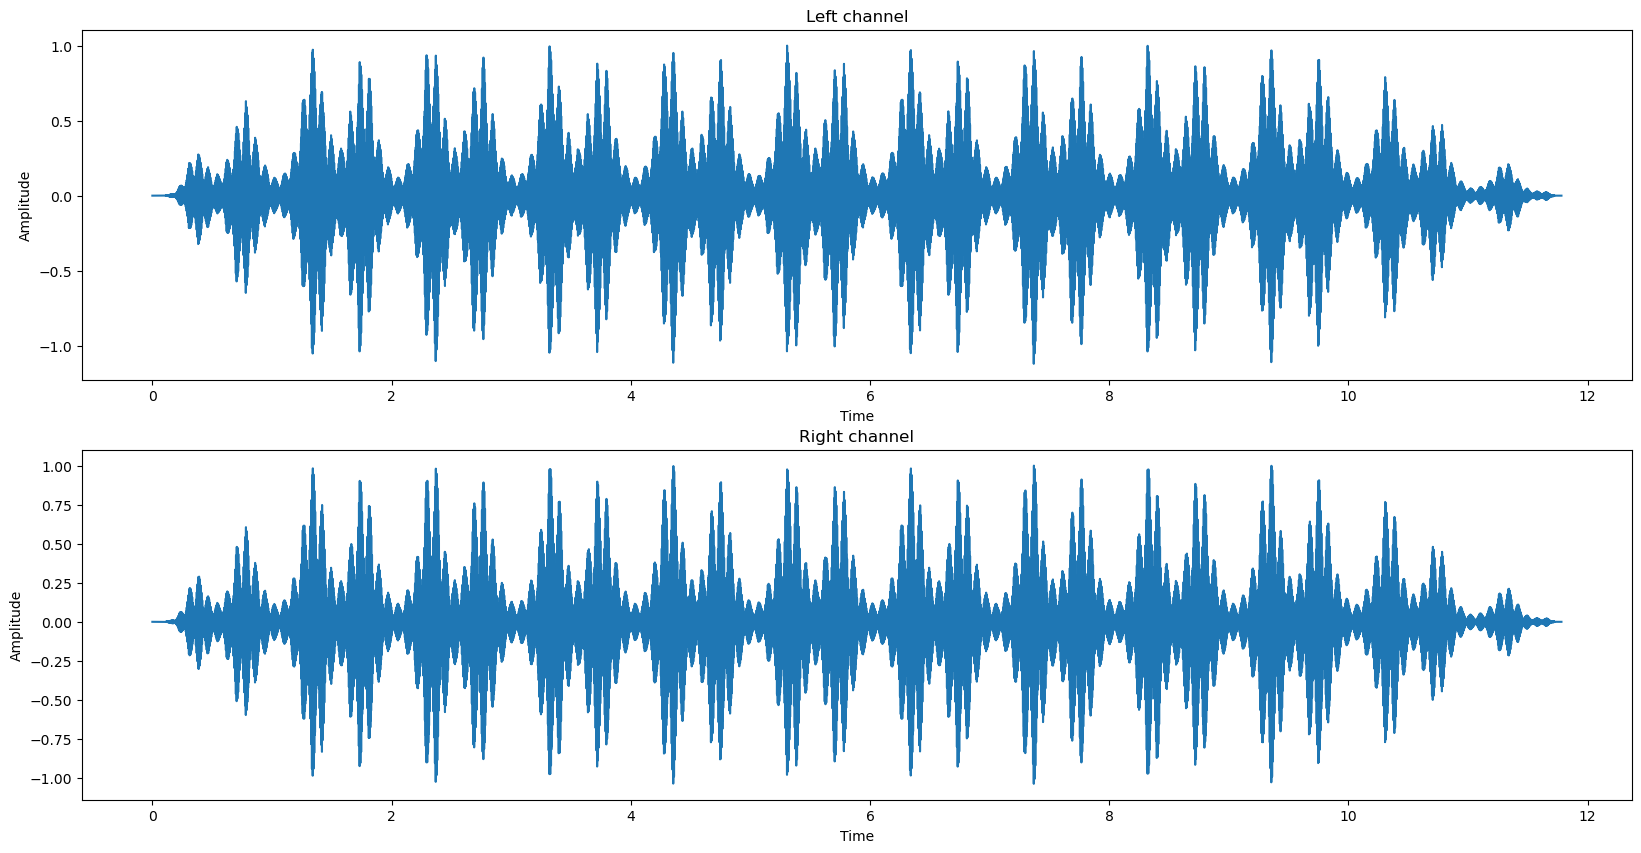

In [4]:
def normalize_signal(signal: np.array, to_value: float = None) -> np.array:
    left = signal[:, 0]
    right = signal[:, 1]

    max_left = np.max(left)
    max_right = np.max(right)

    return np.array([
        left / max_left,
        right / max_right
    ]).T


def draw_signal_amplitude(left: np.array, right: np.array) -> None:
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(2, 1, 1)
    ax.plot(np.linspace(0, signal_length, left.shape[0]), left)
    ax.set_title('Left channel')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    ax = plt.subplot(2, 1, 2)
    ax.plot(np.linspace(0, signal_length, right.shape[0]), right)
    ax.set_title('Right channel')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    plt.show()
    

data = normalize_signal(data)
draw_signal_amplitude(data[:, 0], data[:, 1])

Zamiana sygnału do skali logarytmicznej (decybelowej) oraz jego wizualizacja:

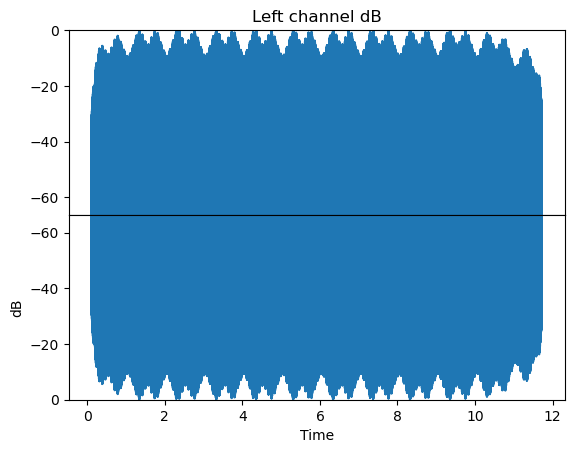

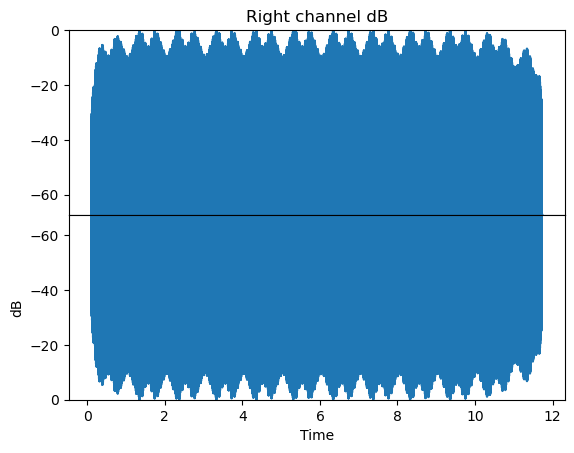

In [5]:
def prepare_signal_to_draw_db(signal_db: np.array) -> np.array:
    left = signal_db[:, 0]
    right = signal_db[:, 1]

    left_min_db = np.nanmin(left[left != -np.inf])
    left_db = left.copy()
    left_db[np.where(np.isnan(left_db))] = left_min_db

    right_min_db = np.nanmin(right[right != -np.inf])
    right_db = right.copy()
    right_db[np.where(np.isnan(right_db))] = right_min_db

    return np.array([left_db, right_db]).T


def draw_signal_db(signal_db: np.array) -> None:
    prepared_signal = prepare_signal_to_draw_db(signal_db)
    left = prepared_signal[:, 0]
    right = prepared_signal[:, 1]

    left_min = np.min(left[left != -np.inf])
    right_min = np.min(right[right != -np.inf])

    plt.subplots_adjust(hspace=0)
    ax = plt.subplot(2, 1, 1)
    plt.title('Left channel dB')
    ax.plot(np.linspace(0, signal_length, left.shape[0]), left)
    # ax.set_yticks(np.arange(0, left_min, -20))
    ax.set_xticks([])
    ax.margins(0.05, 0)

    ax = plt.subplot(2, 1, 2)
    ax.invert_yaxis()
    # ax.set_position([0.125, 0.49, 0.775, 0.19])
    ax.plot(np.linspace(0, signal_length, left.shape[0]), left)
    ax.set_xlabel('Time')
    ax.set_ylabel('dB')
    # ax.set_yticks([np.arange(0, left_min, -20)])
    ax.margins(0.05, 0)

    plt.show()

    plt.subplots_adjust(hspace=0)
    ax = plt.subplot(2, 1, 1)
    plt.title('Right channel dB')
    ax.plot(np.linspace(0, signal_length, right.shape[0]), right, label='plus')
    # ax.set_yticks(np.arange(0, left_min_db, -20))
    ax.set_xticks([])
    ax.margins(0.05, 0)

    ax = plt.subplot(2, 1, 2)
    ax.invert_yaxis()
    # ax.set_position([0.125, 0.53, 0.775, 0.19])
    ax.plot(np.linspace(0, signal_length, right.shape[0]), right)
    ax.set_xlabel('Time')
    ax.set_ylabel('dB')
    # ax.set_yticks(np.arange(0, left_min_db, -20))
    ax.margins(0.05, 0)

    plt.show()
    
    
def transform_amplitude_to_db(signal: np.array) -> np.array:
    left = signal[:, 0]
    right = signal[:, 1]

    max_left = np.max(left)
    max_right = np.max(right)

    return np.array([
        10 * np.log10(left / max_left),
        10 * np.log10(right / max_right)
    ]).T


with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    data_db = transform_amplitude_to_db(data)
    draw_signal_db(data_db)

Monofonizacja sygnału z wykorzystaniem wartości średniej oraz wizualizacja:

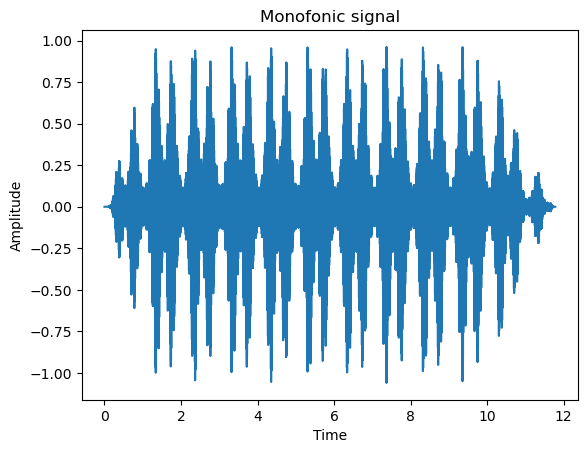

In [6]:
def monophonize_signal_by_mean(signal: np.array) -> np.array:
    return signal.sum(axis=1) / 2


def draw_monophonic_signal(signal: np.array) -> None:
    plt.figure()
    plt.plot(np.linspace(0, signal_length, signal.shape[0]), signal)

    plt.title('Monofonic signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.show()

monophonic_signal = monophonize_signal_by_mean(data)
draw_monophonic_signal(monophonic_signal)

Wyznaczenie składowej stałej jako średniej wartości dla każdego kanału oraz jej usunięcie i wizualizacja:

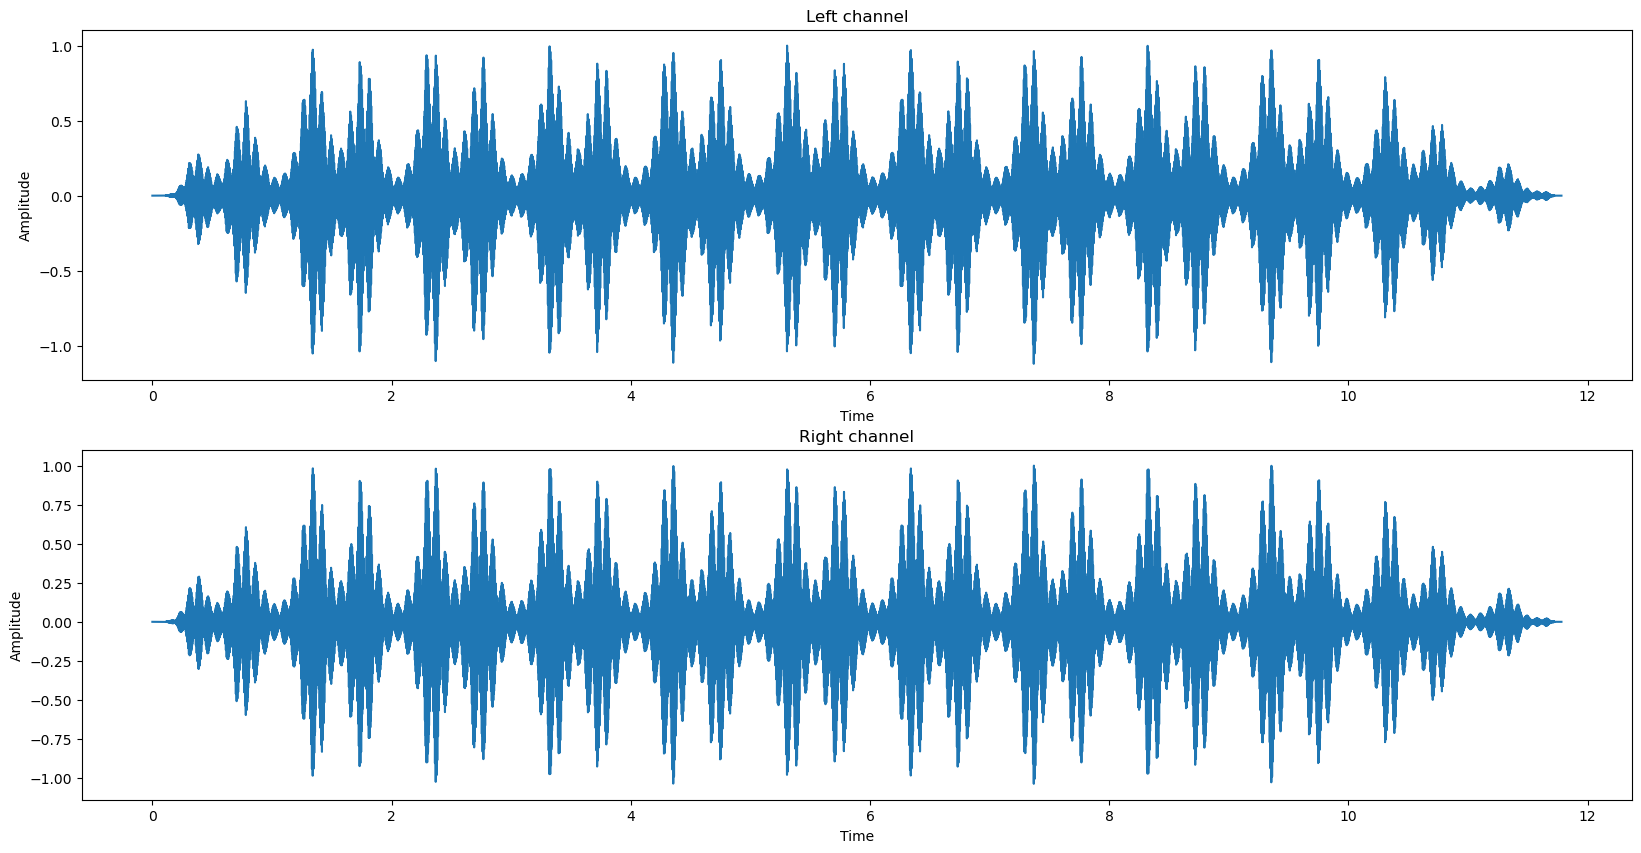

In [7]:
def remove_const_value(signal: np.array):
    mean_amplitude_left = np.mean(signal[:, 0])
    mean_amplitude_right = np.mean(signal[:, 1])

    return np.array([
        signal[signal[:, 0] != mean_amplitude_left, 0],
        signal[signal[:, 1] != mean_amplitude_right, 1],
    ]).T


signal_with_removed_const_value = remove_const_value(data)
draw_signal_amplitude(signal_with_removed_const_value[:, 0], signal_with_removed_const_value[:, 1])

Poniżej definicja klasy pomocniczej wykorzystanej do zmiany częstotliwości sygnału:

Parametry:
* `signal` - dane opisujące wczytany z pliku sygnał
* `samplerate` - częstotliwość próbkowania sygnału

Metody:
* `change_samplerate` - publiczna metoda zwracająca nową instancję tej samej klasy z sygnałem o podanej nowej częstotliwości
* `shape` - pomocnicza metoda służąca jako właściwość celem łatwiejszego wytwarzania kodu
* `__down_sample_signal` - prywatna metoda zmniejszająca częstotliwość sygnału do podanej częstotliwości. Wyliczana jest proporcja obecnej częstotliwości do nowej, a następnie wybierane są próbki z oryginalnego sygnału o odpowiednich indeksach.
* `__up_sample_signal` - prywatna metoda zwiększająca częstotliwość sygnału do podanej częstotliwości. Po wyliczeniu proporcji częstotliwości, odpowiednie próbki o indeksach uwzględnionych z `ratio` z sygnału są przepisywane do macierzy wyjściowej, a reszta nieznanych próbek jest wypełniona wartościami NaN. Następnie wyszukiwane są luki wypełnione wartościami NaN, a w ich miejsce jest wstawiana średnia wartość z lewego końca luki oraz prawego końca luki.

In [8]:
class Signal:
    def __init__(self, signal: np.array, samplerate: int):
        self.signal: np.array = signal
        self.samplerate: int = samplerate

    def change_samplerate(self, new_samplerate: int):
        return Signal(
            self.__down_sample_signal(new_samplerate) if new_samplerate < self.samplerate else self.__up_sample_signal(new_samplerate),
            new_samplerate
        )

    @property
    def shape(self):
        return self.signal.shape

    def __down_sample_signal(self, samplerate: int) -> np.array:
        ratio = samplerate / self.samplerate

        return self.signal[np.unique(np.around(np.arange(self.shape[0]) * ratio).astype(int)), :]

    def __up_sample_signal(self, samplerate: int) -> np.array:
        ratio = samplerate / self.samplerate
        new_samples = np.full((np.round(self.shape[0] * ratio).astype(int), self.shape[1]), np.nan)

        for dim in range(self.shape[1]):
            new_samples[np.around(np.arange(self.shape[0]) * ratio).astype(int), dim] = self.signal[:, dim]

            start_nan_index = -1

            for sample_iter, sample in enumerate(new_samples[:, dim]):
                if np.isnan(sample) and start_nan_index == -1:
                    start_nan_index = sample_iter
                    continue

                if not np.isnan(sample) and start_nan_index != -1:
                    mean_between_samples = np.mean([new_samples[start_nan_index - 1, dim], new_samples[sample_iter, dim]])
                    new_samples[start_nan_index - 1:sample_iter + 1] = mean_between_samples
                    start_nan_index = -1
                    continue

        return new_samples

In [9]:
signal = Signal(data, samplerate)
changed = signal.change_samplerate(48000)
returned = changed.change_samplerate(signal.samplerate)
mse = mean_squared_error(signal.signal, returned.signal)
print(f'MSE for upsampling = {mse}')

MSE for upsampling = 0.09809238965803382


Błąd średniokwadratowy wynosi 9% co nie świadczy najlepiej o algorytmie zmianie częstotliwości próbkowania. Zależnie od podejścia 9% to mogą być niedopuszczalne straty w sygnale lub straty dopuszczalne.